### SPARK: TIME ANALYSIS

## Description
3 studies on the data provided in the file tripdata_2017_01.csv
    1. Average speed of taxis in terms of the hour
    2. Most common taxi trips
    3. Financial records (tips, persons, etc)
We are going to use Spark's API (RDDs), dataframes and direct SQL.

In [1]:
pip install findspark

Note: you may need to restart the kernel to use updated packages.


In [2]:
import findspark
findspark
from pyspark.sql import SparkSession

#we are going to crate a SparkSession with the name "lab_spark"
spark = SparkSession.builder.appName("lab_spark").getOrCreate()

#obtain the SparkContext from the SparkSession
spark_context = spark.sparkContext

#libraries
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
#import pickle

#import functions and classes from pyspark.sql
from pyspark.sql.functions import col, round, expr, from_unixtime, unix_timestamp, date_format #module to work with columns
from pyspark.sql.types import IntegerType #module to work with integer data types

In [3]:
#we need to calculate the time it takes to read the data
start_time = time.time()

Now, we are going to read the dataset of the taxis

In [4]:
taxi_data_df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").option("timestampFormat", "yyyy-MM-dd HH:mm:ss").option("mode", "PERMISSIVE").load(r"./tripdata_2017_01.csv") 
taxi_data_df.show(5)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|    0.5|       2.0|         0.0|                  0.3|        15.3|
|       1| 2017-01-09 11:32:27|  2017-01-09 11:3

In [5]:
end_time = time.time()
time_to_read=(end_time - start_time)#time it takes to read the data

In [6]:
print('Time it takes to read the data with Spark dataframes: ', time_to_read)

Time it takes to read the data with Spark dataframes:  9.189284563064575


In [7]:
#taxi_data_df.describe().show()

Now, let's clean the data

In [8]:
#we need to calculate the time it takes to clean the data
start_time = time.time()

We are going to calculate the total duration of each trip and remove the ones that have a duration of 0

In [9]:
taxi_data_df = taxi_data_df.withColumn("trip_time_hours", round((unix_timestamp(col("tpep_dropoff_datetime")) - unix_timestamp(col("tpep_pickup_datetime"))) / 3600, 2)) #calculate the trip time in hours
taxi_data_df = taxi_data_df.filter(col('trip_time_hours') >= 0)

In [10]:
#now let's count how many of them do we have

In [11]:
taxi_data_df.count()

971010

We are going to remove rows <=0 (tip_amount, total_amount, fare_amount, mta_tax)

In [12]:
#filter values of tips and other taxes lower than 0

#for column in ["tip_amount", "tolls_amount", "improvement_surcharge", "total_amount"]:
    #taxi_data_df = taxi_data_df.filter(col(column) >= 0)
#¡¡¡¡¡¡¡¡DUDA DE SI total_amount Y fare_amount SOLO DESCARTAR LOS >0 Y DEJAR LOS =0!!!!!!!!!!!!!!!!!

for column in ['tip_amount', 'mta_tax']:
    taxi_data_df = taxi_data_df.filter(taxi_data_df[column] >= 0)

In [13]:
for column in ['fare_amount', 'total_amount']:
        taxi_data_df = taxi_data_df.filter(taxi_data_df[column] > 0)

In [14]:
taxi_data_df.count()

970238

In [15]:
end_time = time.time()
time_data_cleaning = end_time - start_time#time it takes to clean the data

In [16]:
print('Time it takes to clean the data with Spark dataframes: ', time_data_cleaning)

Time it takes to clean the data with Spark dataframes:  6.320282459259033


### **STUDY 1: AVERAGE SPEED OF TAXIS IN TERMS OF THE HOUR**

In this study, we will calculate the average speed of New York taxis for each hour of the day to analyze traffic patterns in the city. This analysis has been conducted using dataframes, RDD, SQL, and Pandas. The steps we followed are as follows:

    1. Convert trip distance from miles to kilometers.
    2. Calculate speed by dividing the trip distance by the previously calculated trip duration.
    3. Group the data by the hour of the day and compute the average speed.
    4. Finally, we plot the results.

**With RDD**

In [17]:
taxi_df = taxi_data_df.alias('taxi_df')
taxi_df.show(3)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+---------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|trip_time_hours|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+---------------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|    0.5|       2.0|         0.0|                  0.3|        15.3| 

In [18]:
#function to calculate the time elapsed in hours to know the duration of the trips
def compute_hours_elapsed(start_time, end_time):
    time_diff = (end_time - start_time).total_seconds() / 3600
    return np.round(time_diff, 3)

In [40]:
# Extract the necessary columns as RDDs
distance_rdd = taxi_df.select('trip_distance').rdd.map(lambda x: x[0])
dropoff_time_rdd = taxi_df.select('tpep_dropoff_datetime').rdd.map(lambda x: x[0])
pickup_time_rdd = taxi_df.select('tpep_pickup_datetime').rdd.map(lambda x: x[0])

# Convert distance to kilometers
distance_km_rdd = distance_rdd.map(lambda x: np.round(x * 1.609344, 3))

# Create an RDD with pickup and dropoff datetime pairs
datetime_rdd = taxi_df.select('tpep_pickup_datetime', 'tpep_dropoff_datetime').rdd.map(lambda x: (x[0], x[1]))

# Calculate trip duration in hours
trip_duration_rdd = datetime_rdd.map(lambda x: calculate_elapsed_hours(x[0], x[1]))

# Zip the distance (km) with trip duration (hours)
distance_time_rdd = distance_km_rdd.zip(trip_duration_rdd)

# Calculate the average trip speed (km/h), handle zero duration cases
speed_rdd = distance_time_rdd.map(lambda x: np.round(x[0] / x[1], 3) if x[1] > 0 else 0)

# Extract the hour from pickup datetime
hour_rdd = pickup_time_rdd.map(lambda x: x.hour)

# Create a key-value pair (hour, 1) to count the number of trips per hour
key_hour_rdd = hour_rdd.map(lambda x: (x, 1))

# Reduce by key to get the total number of trips per hour
hour_trip_count_rdd = key_hour_rdd.reduceByKey(lambda x, y: x + y)

# Create a key-value pair (hour, speed) to sum the speeds per hour
hour_speed_rdd = hour_rdd.zip(speed_rdd)

# Reduce by key (hour) to get the total speed sum per hour
hour_speed_sum_rdd = hour_speed_rdd.reduceByKey(lambda x, y: np.round(x + y, 3))

# Calculate the average speed per hour by dividing the total speed sum by the number of trips per hour
avg_speed_per_hour_rdd = hour_speed_sum_rdd.join(hour_trip_count_rdd).map(lambda x: (x[0], np.round(x[1][0] / x[1][1], 3)))

# Sort the hours for visualization purposes
sorted_hours_rdd = hour_trip_count_rdd.map(lambda x: x[0])

# Measure execution time
start_time = time.time()

# Collect the results
avg_speed_per_hour_list = avg_speed_per_hour_rdd.collect()
sorted_hours_list = sorted_hours_rdd.collect()

end_time = time.time()
execution_time = end_time - start_time

# Print execution time
print('Execution time for Spark RDD task:', execution_time)

# Print the result
for hour, avg_speed in sorted(avg_speed_per_hour_list):
    print(f'Hour: {hour}, Avg Speed: {avg_speed}')


Execution time for Spark RDD task: 29.084811687469482
Hour: 0, Avg Speed: 25.34
Hour: 1, Avg Speed: 23.889
Hour: 2, Avg Speed: 25.316
Hour: 3, Avg Speed: 28.121
Hour: 4, Avg Speed: 32.848
Hour: 5, Avg Speed: 35.234
Hour: 6, Avg Speed: 31.218
Hour: 7, Avg Speed: 23.536
Hour: 8, Avg Speed: 22.763
Hour: 9, Avg Speed: 21.658
Hour: 10, Avg Speed: 23.173
Hour: 11, Avg Speed: 21.327
Hour: 12, Avg Speed: 21.213
Hour: 13, Avg Speed: 20.677
Hour: 14, Avg Speed: 22.866
Hour: 15, Avg Speed: 20.481
Hour: 16, Avg Speed: 26.025
Hour: 17, Avg Speed: 21.265
Hour: 18, Avg Speed: 21.137
Hour: 19, Avg Speed: 24.748
Hour: 20, Avg Speed: 23.592
Hour: 21, Avg Speed: 24.49
Hour: 22, Avg Speed: 27.589
Hour: 23, Avg Speed: 31.044


In [36]:
print(average_speed_hour_list)

[(0, nan), (8, nan), (16, nan), (9, nan), (17, nan), (1, nan), (10, nan), (2, nan), (18, nan), (11, nan), (3, nan), (19, nan), (12, nan), (4, nan), (20, nan), (13, nan), (5, nan), (21, nan), (6, nan), (14, nan), (22, nan), (7, nan), (15, nan), (23, nan)]


In [39]:
print(ordered_hours_list)

[0, 8, 16, 9, 17, 1, 10, 2, 18, 11, 3, 19, 12, 4, 20, 13, 5, 21, 6, 14, 22, 7, 15, 23]


In [ ]:
print(average_speed_hour_list[0][1])

In [37]:
first_values = [x[0] for x in average_speed_hour_list]

# Second list for the second elements (average speeds)
second_values = [x[1] for x in average_speed_hour_list]

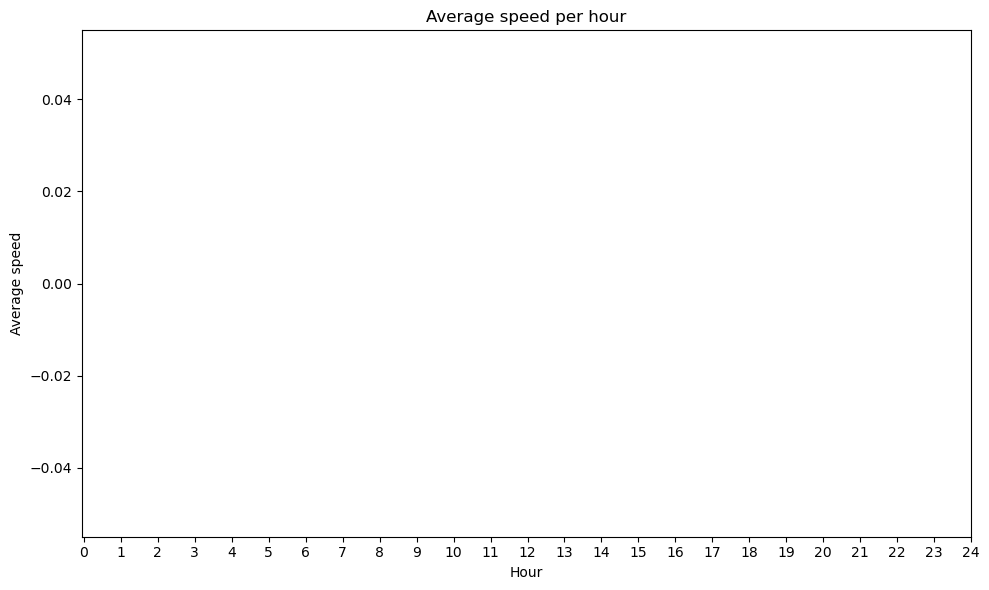

In [38]:
# Initialize a new figure with a defined size (10 inches wide by 6 inches tall)
fig, ax = plt.subplots(figsize=(10, 6))

#line plot, using hours for the x-axis and average speed for the y-axis
sns.lineplot(x=first_values, y=second_values, ax=ax, color='blue')

ax.set_xlabel("Hour")
ax.set_ylabel("Average speed")
ax.set_title("Average speed per hour")
ax.set_xticks(range(25))
ax.set_xticklabels(range(25), rotation=0)

plt.tight_layout()
plt.show()

**With dataframes**

In [26]:
taxi_df = taxi_data_df.alias('taxi_data_df')
taxi_df.show(3)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+---------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|trip_time_hours|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+---------------+
|       1| 2017-01-09 11:13:28|  2017-01-09 11:25:45|              1|          3.3|         1|                 N|         263|         161|           1|       12.5|  0.0|    0.5|       2.0|         0.0|                  0.3|        15.3| 

In [27]:
dropoff_df = taxi_data_df.select('tpep_dropoff_datetime')
pickup_df = taxi_data_df.select('tpep_pickup_datetime')

taxi_df = taxi_data_df.withColumn("trip_distance_km", round(taxi_data_df["trip_distance"] * 1.609344, 3))

taxi_df = taxi_df.withColumn("trip_duration_hours", (unix_timestamp("tpep_dropoff_datetime") - unix_timestamp("tpep_pickup_datetime")) / 3600)

taxi_df = taxi_df.withColumn("trip_speed_km_h", round(taxi_df['trip_distance_km'] / taxi_df['trip_duration_hours'], 3))

# Extract the hour from pickup datetime and format it
taxi_df = taxi_df.withColumn("hour_time", date_format(taxi_df["tpep_pickup_datetime"], "HH"))

# Group by hour and calculate average trip speed
hours_speed_df = taxi_df.groupBy("hour_time").agg({"trip_speed_km_h": "mean"})

hours_speed_df = hours_speed_df.withColumn("hour_time", hours_speed_df["hour_time"].cast(IntegerType()))

start_time = time.time()
hours_speed_df_pd = hours_speed_df.toPandas()
end_time = time.time()

task1_spark_df_time = end_time - start_time
print('Execution time for Spark DataFrames task:', task1_spark_df_time)


Execution time for Spark DataFrames task: 2.8028087615966797


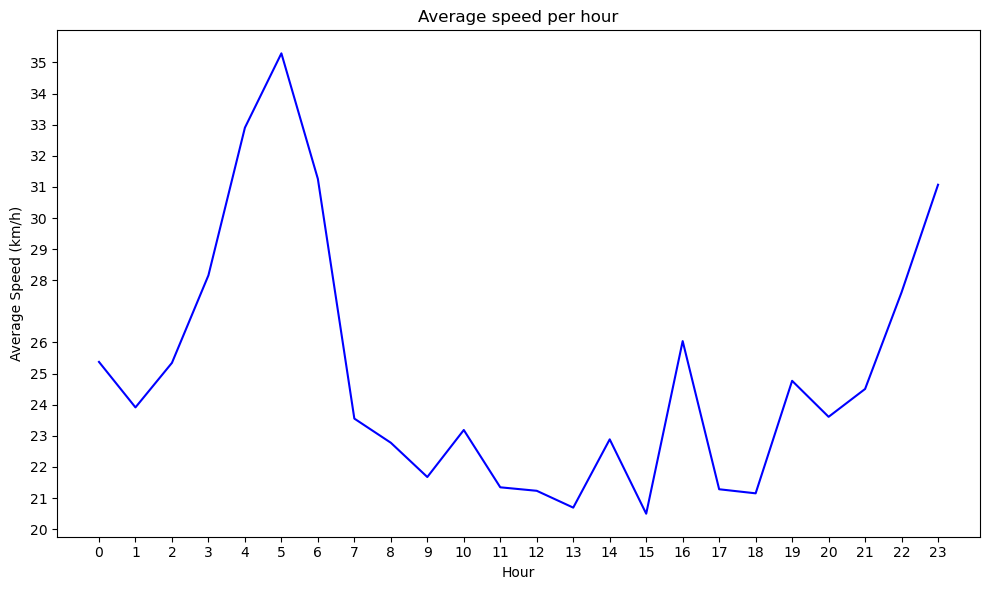

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))

# Line plot, using hours for the x-axis and average speed for the y-axis
sns.lineplot(x="hour_time", y="avg(trip_speed_km_h)", data=hours_speed_df_pd, ax=ax, color='blue')

ax.set_xlabel("Hour")
ax.set_ylabel("Average Speed (km/h)")
ax.set_title("Average speed per hour")

ax.set_xticks(range(0, 24))
ax.set_xticklabels(range(0, 24), rotation=0)

#minimum and maximum speed for y-ticks
min_value = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].min())
max_value = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].max())
ysticks_ = np.unique(np.round(np.linspace(min_value, max_value, 15)))

ax.set_yticks(ysticks_)
plt.tight_layout()
plt.show()


**With SQL**

In [ ]:
taxi_df = taxi_data_df.alias('taxi_data_df')
taxi_df.show(3)

In [ ]:
# Create temporary views for SQL queries
taxi_data_df.createOrReplaceTempView("taxi_data")

# Use SQL to calculate trip distances in kilometers, duration, speed, and extract hour
sql_query = """
SELECT 
    tpep_pickup_datetime,
    tpep_dropoff_datetime,
    ROUND(trip_distance * 1.609344, 3) AS trip_distance_km,
    (UNIX_TIMESTAMP(tpep_dropoff_datetime) - UNIX_TIMESTAMP(tpep_pickup_datetime)) / 3600 AS trip_duration_hours,
    ROUND(ROUND(trip_distance * 1.609344, 3) / ((UNIX_TIMESTAMP(tpep_dropoff_datetime) - UNIX_TIMESTAMP(tpep_pickup_datetime)) / 3600), 3) AS trip_speed_km_h,
    DATE_FORMAT(tpep_pickup_datetime, 'HH') AS hour_time
FROM taxi_data
"""

# Execute the SQL query and create a new DataFrame
taxi_df = spark.sql(sql_query)

# Group by hour and calculate average trip speed
hours_speed_df = taxi_df.groupBy("hour_time").agg({"trip_speed_km_h": "mean"})

# Convert the "hour_time" column to integer type
hours_speed_df = hours_speed_df.withColumn("hour_time", hours_speed_df["hour_time"].cast(IntegerType()))

# Measure execution time for the SQL operation
start_time = time.time()
hours_speed_df_pd = hours_speed_df.toPandas()  # Convert the DataFrame to a Pandas DataFrame for further analysis
end_time = time.time()

# Calculate and print the execution time
task1_spark_sql_time = end_time - start_time
print('Execution time for Spark SQL task:', task1_spark_sql_time)


In [ ]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.lineplot(x="hour_time", y="avg(trip_speed_km_h)", data=hours_speed_df_pd, ax=ax, color='blue')

ax.set_xlabel("Hour")
ax.set_ylabel("Average Speed (km/h)")
ax.set_title("Average Speed Per Hour")

#x-ticks to represent each hour of the day
ax.set_xticks(range(0, 24))
ax.set_xticklabels(range(0, 24), rotation=0)

#minimum and maximum average speeds for y-ticks
min_value = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].min())
max_value = np.round(hours_speed_df_pd["avg(trip_speed_km_h)"].max())
ysticks_ = np.unique(np.round(np.linspace(min_value, max_value, 15)))

ax.set_yticks(ysticks_)
plt.tight_layout()
plt.show()